<a href="https://colab.research.google.com/github/venkateshakula1729/GenAI-Fusion/blob/main/GAN_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Merry Christmas!!


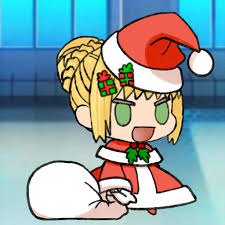

# GANS


---


### In this assignment your have to implement both FCGANs and DCGANs of the given dataset using the code for **newer tensorflow version** i reffered in the last doc. [Link to DCGANs implementation in newer tensorflow](https://colab.research.google.com/drive/1FQritxUIJBxriq-gPG4fdulA2dHoMnoF#scrollTo=mVPhd0B_vJG8)
If you face any difficulty understating the code then tell me I may take a session on it or try to explain it to you.



---
## Detailed Assignment Explanation :-

### **Implementation and Training**

* You are required to implement and train both Fully Connected GAN (FCGAN) and

* Deep Convolutional GAN (DCGAN) on the same dataset.

* Use a fixed noise vector (randomly initialized before training) for generating images during each epoch.

### **Generating Images During Training**

* At the end of each epoch, use the fixed noise vector to generate an image.

* Save these generated images for both FCGAN and DCGAN.

### **Visualizing and Comparing Epoch vs Image Quality**

* Create a grid visualization to display the progression of generated images over epochs for each model. The grids should:

* Use the same noise vector for consistency.

* Have rows or columns labeled with the epoch numbers.

* Allow side-by-side comparison between FCGAN and DCGAN.

### **Example for 25 Epochs**

* If you train for 25 epochs, create a 5x5 grid for both FCGAN and DCGAN. Each cell of the grid represents the image generated at a particular epoch.

* Ensure that the epoch number is clearly labeled for each cell.

* Arrange the grids so you can easily compare the image quality progression between FCGAN and DCGAN.



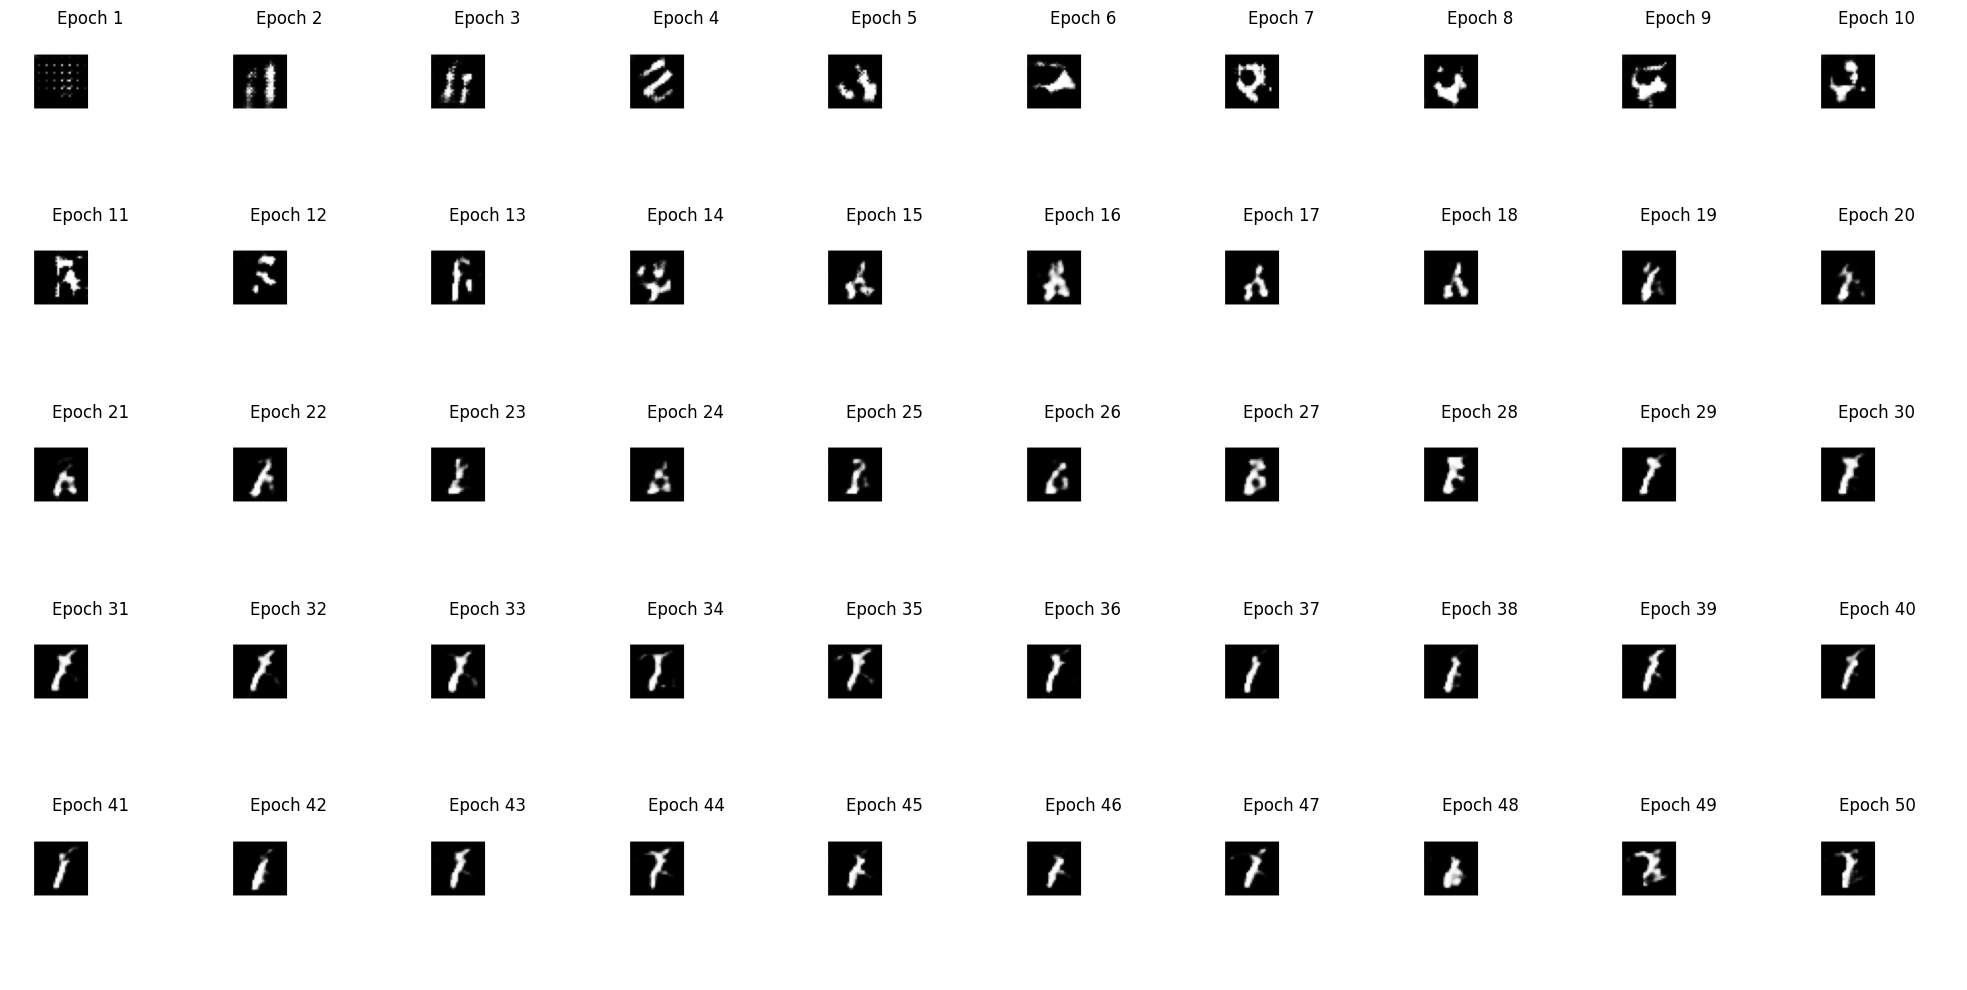

Something like this or better for both DCGAN and FCGAN.

Try adding Batch Norm layers or anything to improve performance


In [ ]:
# Imported Libraries according to the same file shared with you

# Importing Libraries

In [ ]:
import tensorflow as tf
import cv2

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-uwoalcqq
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-uwoalcqq
  Resolved https://github.com/tensorflow/docs to commit bbc0b9c70fc0bd4411793d1b0bcc56ef1dbc2405
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.11.18.43811-py3-none-any.whl size=186671 sha256=3f24b4053c3c7cd56558e66f918921bf63cb214a7ec825fdb543a4bb587bbf9a
  Stored in directory: /tmp/pip-ephem-wheel-cache-picvst_d/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

# Loading MNIST Dataset

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() # Importing Datasets
# (28*28*1) - Here 1 represents the channels 1-Greyscale, 3-RGB.
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') # Reshaping into (No. Of Images,28,28,1) and converting to flaot32
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]


BUFFER_SIZE = 60000
BATCH_SIZE = 256


# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# FCGAN and DCGAN Model Structure

In [ ]:
# FCGAN Generator
def build_fcgan_generator():
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(100,)),
        layers.Dense(256, activation='relu'),
        layers.Dense(28 * 28 * 1, activation='tanh'),
        layers.Reshape((28, 28, 1))
    ])
    return model

# FCGAN Discriminator
def build_fcgan_discriminator():
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=(28, 28, 1)),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
# DCGAN Generator
def build_dcgan_generator():
    model = tf.keras.Sequential()

    # Fully connected layer
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape to 7x7x256
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # None is the batch size

    # First Conv2DTranspose
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second Conv2DTranspose
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Output Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)  # Output: 28x28x1 image

    return model

# DCGAN Discriminator
def build_dcgan_discriminator():
    model = tf.keras.Sequential()

    # First Conv2D layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second Conv2D layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten and output layer
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

## Loss Functions

In [ ]:
# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

dcgan_generator_optimizer = tf.keras.optimizers.Adam(1e-4)
dcgan_discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
nv = tf.random.normal([BATCH_SIZE, 100])

#@tf.function
def train_step(generator, discriminator, images, noise_dim, generator_optimizer, discriminator_optimizer):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
EPOCHS = 25
noise_dim = 100
num_examples_to_generate = 16

# Fixed seed for consistent image generation
seed = tf.random.normal([num_examples_to_generate, noise_dim])

def train(generator, discriminator, dataset, epochs, generator_optimizer, discriminator_optimizer, model_name):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(generator, discriminator, image_batch, noise_dim, generator_optimizer, discriminator_optimizer)

        # Produce images for the GIF as we go
        generate_and_save_images(generator, epoch + 1, seed, model_name)

        print(f'Epoch {epoch + 1}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}')
        #print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

import os

def generate_and_save_images(model, epoch, test_input, model_name):
    predictions = model(test_input, training=False)

    # Create a directory for saving images if not exists
    output_dir = f'./{model_name}_images'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save the generated image
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig(f'{output_dir}/{model_name}_epoch_{epoch:03d}.png')
    plt.close(fig)

In [ ]:
def compare_fcgan_dcgan(epochs, grid_size=(5, 5)):
    """
    Create side-by-side grids for FCGAN and DCGAN.

    :param epochs: Total number of epochs.
    :param grid_size: Tuple representing the number of rows and columns in the grid.
    """
    rows, cols = grid_size
    fcgan_dir = './FCGAN_images'
    dcgan_dir = './DCGAN_images'

    # Create figure for FCGAN
    fig_fcgan, axes_fcgan = plt.subplots(rows, cols, figsize=(15, 15))
    axes_fcgan = np.array(axes_fcgan).flatten()  # Ensure axes are iterable

    fcgan_images = []
    for epoch in range(1, epochs + 1):
        img_path = f'{fcgan_dir}/FCGAN_epoch_{epoch:03d}.png'
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            fcgan_images.append(img)

    for i, ax in enumerate(axes_fcgan):
        if i < len(fcgan_images):
            ax.imshow(fcgan_images[i])
            ax.axis('off')
            ax.set_title(f'Epoch {i + 1}')
        else:
            ax.axis('off')
    plt.suptitle('FCGAN Progression Over Epochs', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Create figure for DCGAN
    fig_dcgan, axes_dcgan = plt.subplots(rows, cols, figsize=(15, 15))
    axes_dcgan = np.array(axes_dcgan).flatten()  # Ensure axes are iterable

    dcgan_images = []
    for epoch in range(1, epochs + 1):
        img_path = f'{dcgan_dir}/DCGAN_epoch_{epoch:03d}.png'
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            dcgan_images.append(img)

    for i, ax in enumerate(axes_dcgan):
        if i < len(dcgan_images):
            ax.imshow(dcgan_images[i])
            ax.axis('off')
            ax.set_title(f'Epoch {i + 1}')
        else:
            ax.axis('off')
    plt.suptitle('DCGAN Progression Over Epochs', fontsize=16)
    plt.tight_layout()
    plt.show()

## Training

In [ ]:
# Initialize DCGAN models
dcgan_generator = build_dcgan_generator()
dcgan_discriminator = build_dcgan_discriminator()

dcgan_generator(tf.random.normal([1, 100]))
dcgan_discriminator(tf.random.normal([1, 28, 28, 1]))
# Train DCGAN
train(dcgan_generator, dcgan_discriminator, train_dataset, EPOCHS, dcgan_generator_optimizer, dcgan_discriminator_optimizer, 'DCGAN')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1, Generator Loss: 0.695846438407898, Discriminator Loss: 1.4080586433410645
Epoch 2, Generator Loss: 0.8952732682228088, Discriminator Loss: 1.199236512184143
Epoch 3, Generator Loss: 1.2497977018356323, Discriminator Loss: 0.816794753074646
Epoch 4, Generator Loss: 0.8768486976623535, Discriminator Loss: 1.1918855905532837
Epoch 5, Generator Loss: 0.9182412624359131, Discriminator Loss: 1.3343299627304077
Epoch 6, Generator Loss: 0.6105754375457764, Discriminator Loss: 1.694703221321106
Epoch 7, Generator Loss: 0.9515750408172607, Discriminator Loss: 1.065859317779541
Epoch 8, Generator Loss: 0.8331283330917358, Discriminator Loss: 1.2563281059265137
Epoch 9, Generator Loss: 0.7950128316879272, Discriminator Loss: 1.3961105346679688
Epoch 10, Generator Loss: 0.8675997257232666, Discriminator Loss: 1.1886889934539795
Epoch 11, Generator Loss: 1.1585447788238525, Discriminator Loss: 0.8607562184333801
Epoch 12, Generator Loss: 1.0463522672653198, Discriminator Loss: 1.13051152229

In [ ]:
# Initialize FCGAN models
fcgan_generator = build_fcgan_generator()
fcgan_discriminator = build_fcgan_discriminator()
fcgan_generator(tf.random.normal([1, 100]))
fcgan_discriminator(tf.random.normal([1, 28, 28, 1]))
fcgan_generator_optimizer = tf.keras.optimizers.Adam(1e-4)
fcgan_discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Train FCGAN
train(fcgan_generator, fcgan_discriminator, train_dataset, EPOCHS, fcgan_generator_optimizer, fcgan_discriminator_optimizer, 'FCGAN')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1, Generator Loss: 2.1646177768707275, Discriminator Loss: 0.16956672072410583
Epoch 2, Generator Loss: 2.5166401863098145, Discriminator Loss: 0.18300111591815948
Epoch 3, Generator Loss: 2.2312569618225098, Discriminator Loss: 0.2243068814277649
Epoch 4, Generator Loss: 2.7893013954162598, Discriminator Loss: 0.3228899836540222
Epoch 5, Generator Loss: 2.8091464042663574, Discriminator Loss: 0.12730516493320465
Epoch 6, Generator Loss: 2.695746660232544, Discriminator Loss: 0.22391840815544128
Epoch 7, Generator Loss: 3.327422618865967, Discriminator Loss: 0.1531142145395279
Epoch 8, Generator Loss: 2.7346949577331543, Discriminator Loss: 0.25668156147003174
Epoch 9, Generator Loss: 2.4860377311706543, Discriminator Loss: 0.23740145564079285
Epoch 10, Generator Loss: 2.9469451904296875, Discriminator Loss: 0.12773838639259338
Epoch 11, Generator Loss: 2.574817180633545, Discriminator Loss: 0.26558181643486023
Epoch 12, Generator Loss: 3.172515392303467, Discriminator Loss: 0.12

## Comparison of FCGAN and DCGAN

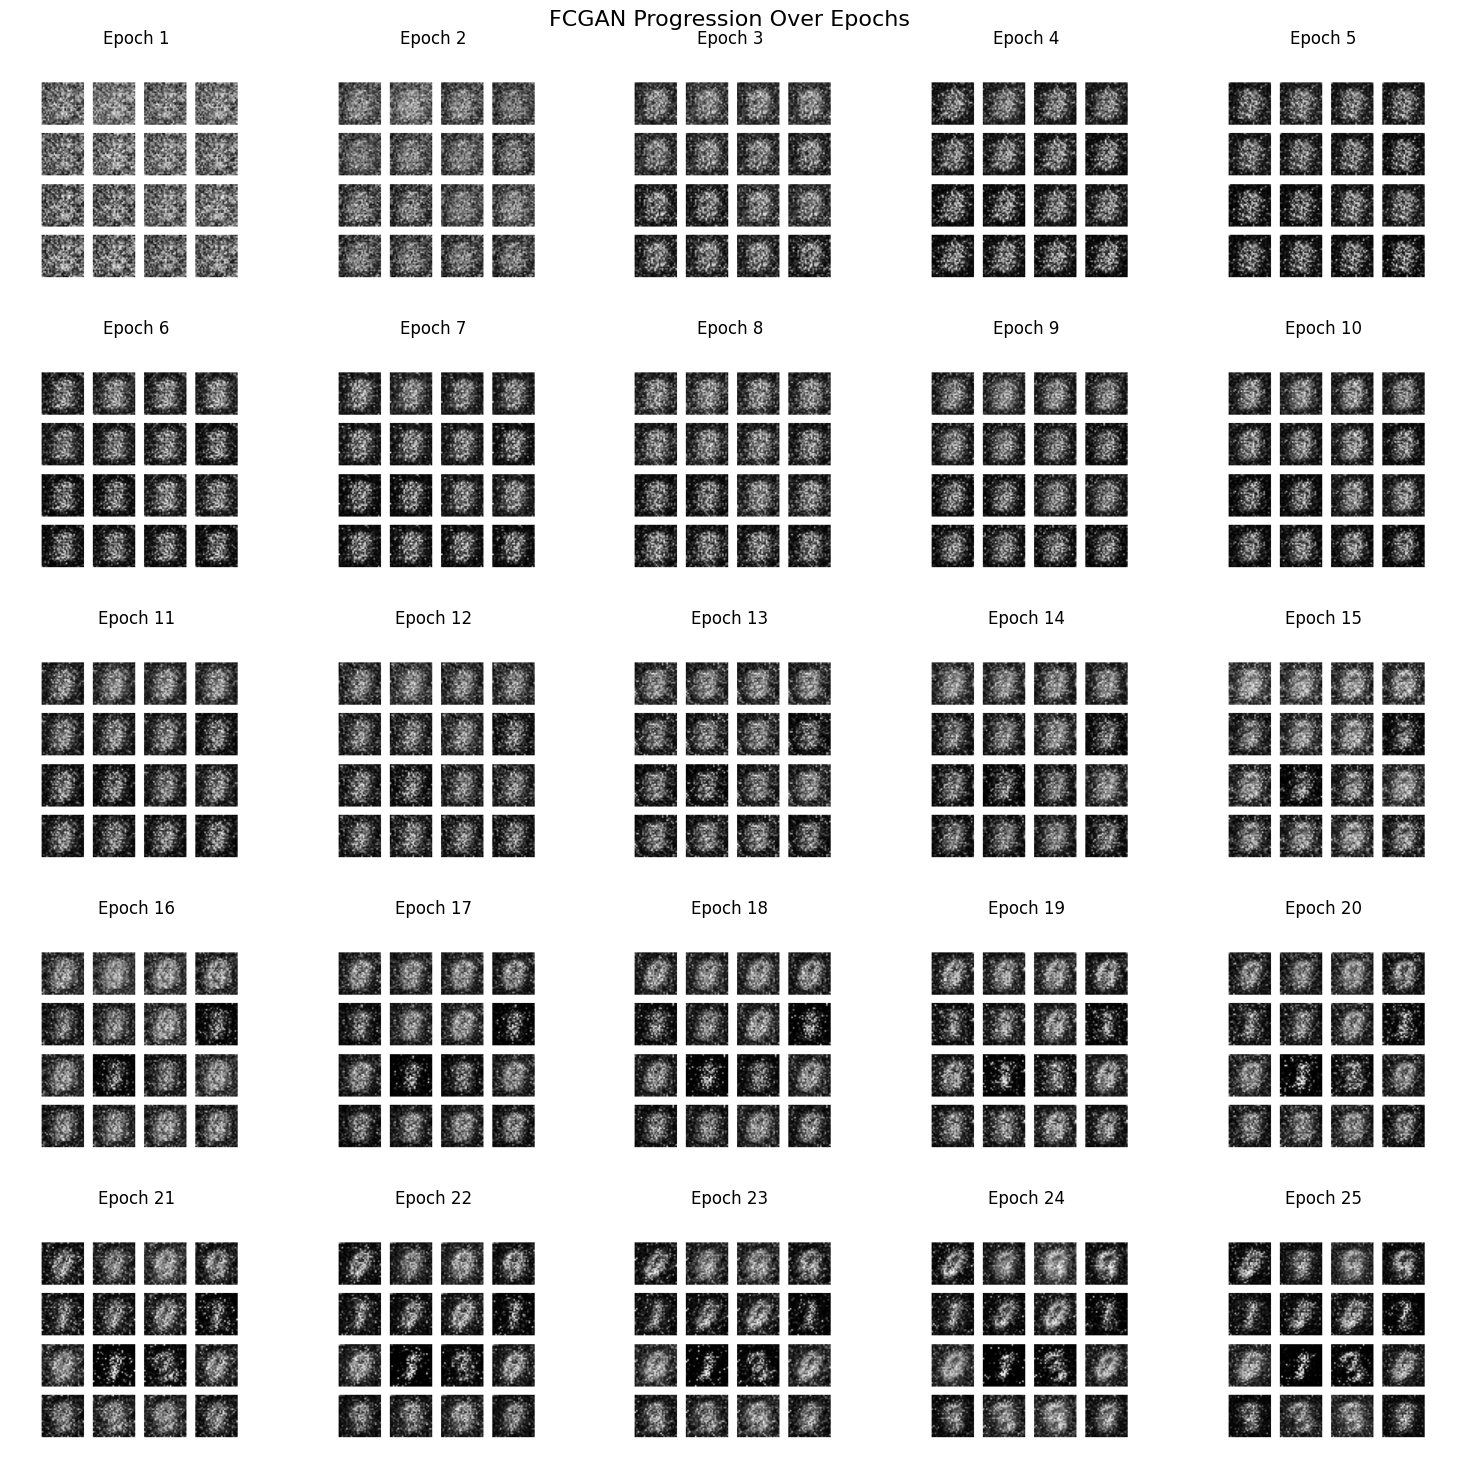

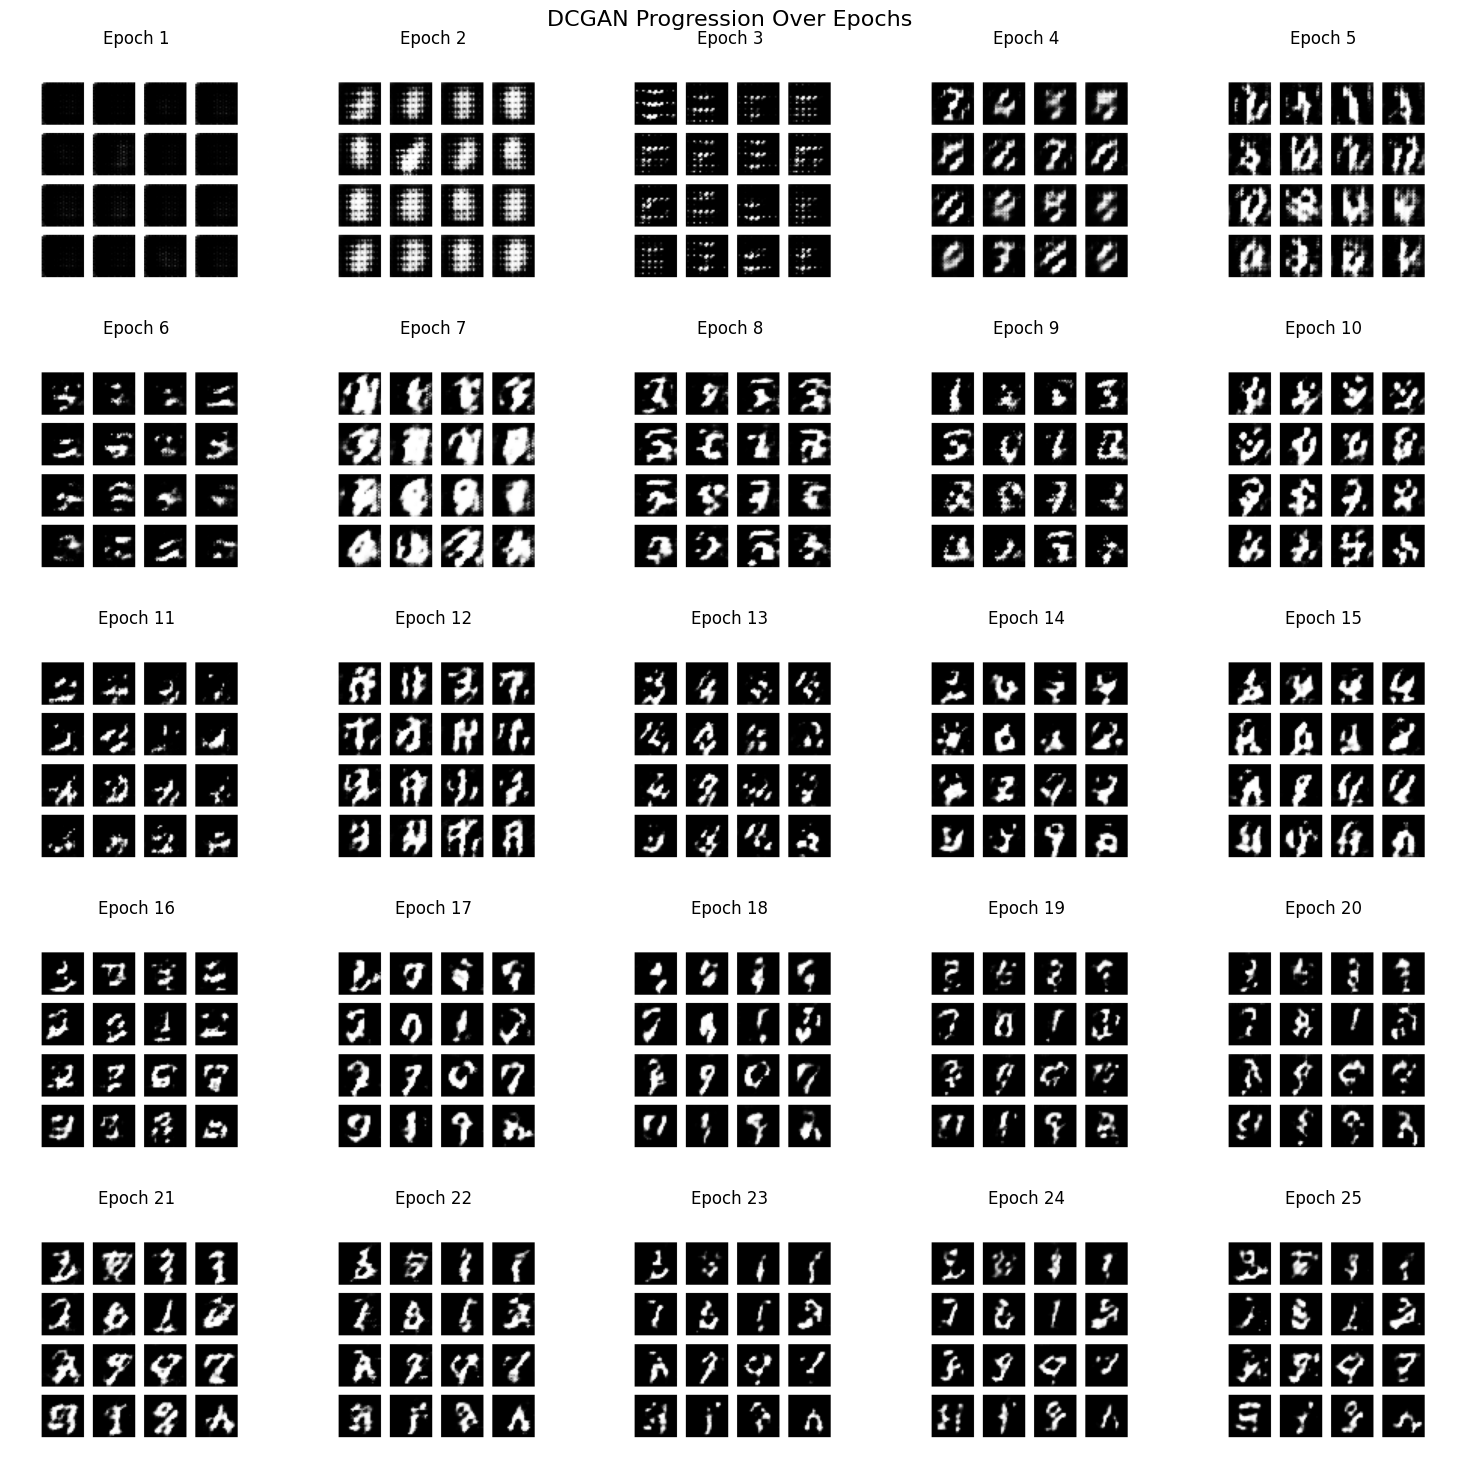

In [ ]:
compare_fcgan_dcgan(EPOCHS, grid_size=(5, 5))